# Perform a looping with the quadrotor

# Goal of the project

The goal of this project is to control a 2D quadrotor to get it to perform acrobatic moves. The controller will be designed using an SQP solver.

Please submit your code as a runnable Jupyter Notebook.

## 2D quadrotor

The quadrotor is depicted in the following figure
<img src='quadrotor.png' width="300">


The quadrotor model is written as
$$\begin{align} 
\dot{p_x} &= v_x\\
m \dot{v}_x &= - (u_1 + u_2) \sin \theta \\ 
\dot{p_y} &= v_y\\
m \dot{v}_y &= (u_1 + u_2) \cos \theta  - m g\\
\dot{\theta} &= \omega\\
I \dot{\omega} &= r (u_1 - u_2) \end{align}$$
where $p_x$ is the horizontal and $p_y$ the vertical positions of the quadrotor and $\theta$ is its orientation with respect to the horizontal plane. $v_x$ and $v_y$ are the linear velocities and $\omega$ is the angular velocity of the robot. $u_1$ and $u_2$ are the forces produced by the rotors (our control inputs). $m$ is the quadrotor mass, $I$ its moment of inertia (a scalar), $r$ is the distance from the center of the robot frame to the propellers and $g$ is the gravity constant. To denote the entire state, we will write $x = [p_x, v_x, p_y, v_y, \theta, \omega]^T$ - we will also write $u = [u_1, u_2]^T$.

The module ```quadrotor.py``` defines the problem and provides all the useful information about the robot and methods to simulate and animate it as shown below.

You can access the different parameters of the model in the following way:

In [231]:
import quadrotor

print("Mass    =", quadrotor.MASS)
print("Length  =", quadrotor.LENGTH)
print("Inertia =", quadrotor.INERTIA)
print("Dt      =", quadrotor.DT)
print("state size   =", quadrotor.DIM_STATE)
print("control size =", quadrotor.DIM_CONTROL)

Mass    = 0.5
Length  = 0.15
Inertia = 0.1
Dt      = 0.04
state size   = 6
control size = 2




## Part 1 - Setting up the trajectory Optimization (50 points)
1. Discretize the system dynamics using the Euler method seen in class - write the time discretization step as $\Delta t$ (use symbols not numbers for the mass, etc)
2. We would like the quadrotor to perfom a looping. Find and implement a suitable cost function to perform a looping and add constraint to maintain the thrust of each rotor between $0$ and $10$. Solve the problem using your own implementation of a SQP (levarging your code from Homework 2) with a large horizon to check that you can do a looping.
3. Show plots of all the states and controls of the robot as a function of time. Describe your design choices (in a concise manner) in the report.

## Part 2 - Model predictive control (MPC) (50 points)
1. Use the trajectory optimization method from Part I to design a MPC controller and test it using the simulator below. In particular, verify that it can handle perturbations by calling the ```quadrotor.simulate``` function with ```disturbance = True``` (when setting disturbance to True, the simulator will generate a random perturbation every 1 second). Simulate your controller for 10 seconds, plot the state anc control evolution.
2. Explain your intended design in the report, including the cost function and found control law

The ```quadrotor.simulate``` function takes as an input an initial state, a controller, the number of discrete time steps and a boolean value to indicate the presence of perturbation. The controller has to be a function taking as an input a state and time index and outputting a control vector.

To visualize the trajectory, use the ```quadrotor.animate_robot``` function
and show the animation (show the plots in your report).

## Bonus (10 points)
Add a state constraint to perform the looping while maintening a positive altitude. Use the origin as an initial state.

In [ ]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
# import matplotlib
# import matplotlib.animation as animation
# import IPython
from scipy.linalg import block_diag
from scipy.sparse import csr_matrix

from qpsolvers import Problem, solve_problem


def controller(x, t):
    return np.zeros(2)

x_init = np.array([0, 0, 0., 0 ,0, 0])
horizon_length = 100
# t, state, u = quadrotor.simulate(x_init, controller, horizon_length, disturbance=True)
# quadrotor.animate_robot(state, u)


## Solution : Part 1 - Setting up the trajectory Optimization (50 points)
### 1. Discretize the system dynamics using the Euler method seen in class - write the time discretization step as $\Delta t$ (use symbols not numbers for the mass, etc)

To discretise the system dynamics, we shall simply rearrange the given dynamic equations such that multiplication with $\Delta t$ will provide the necessary addition to the current state resulting in the next state. This is shown below - 

$$\begin{align*}
    \dot{p}_{x_n} &= v_{x_n} \\
    \dot{v}_{x_n} &= - \frac{(u_{1_n} + u_{2_n}) \sin \theta_n}{m} \\
    \dot{p}_{y_n} &= v_{y_n} \\
    \dot{v}_{y_n} &= \frac{(u_{1_n} + u_{2_n}) \cos \theta_n}{m} - g \\
    \dot{\theta}_n &= \omega_n \\
    \dot{\omega}_n &= r \frac{(u_{1_n} - u_{2_n})}{I} = \frac{L(u_{1_n} - u_{2_n})}{I}  \quad, \quad L = \text{ Length of quadrotor}
\end{align*}$$

This gives us the equality constraints, 
$$\begin{align*}
    p_{x_{n+1}} &= p_{x_n} + \Delta t v_{x_n} \\
    v_{x_{n+1}} &= v_{x_n} - \Delta t \frac{(u_{1_n} + u_{2_n}) \sin \theta_n}{m} \\
    p_{y_{n+1}} &= p_{y_n} + \Delta t v_{y_n} \\
    v_{y_{n+1}} &= v_{y_n} + \Delta t \left(\frac{(u_{1_n} + u_{2_n}) \cos \theta_n}{m} - g \right)\\
    \theta_{n+1} &= \theta_{n} + \Delta t \omega_n \\
    \omega_{n+1} &= \omega_{n} + \Delta t \frac{L(u_{1_n} - u_{2_n})}{I}
\end{align*}$$

As we can see, a couple of the constraints are non-linear. So we must first find a linear approximation of the constraints at a given guess $\bar{x}$ in a form $G(\bar{x}) \Delta x = g(\bar{x})$ where $\Delta x$ represents a small variation around $\bar{x}$. To do that, we shall perform the Taylor Expansion of the constraints around $\bar{x}$, which will be given by, 

$$\begin{align*}
    \Delta p_{x_{n+1}} &= \Delta p_{x_n} + \Delta t \Delta v_{x_n} \\
    \Delta v_{x_{n+1}} &= \Delta v_{x_n} - \Delta t \Delta \theta_n \frac{(u_{1_n} + u_{2_n}) \cos \theta_n}{m} - \Delta t (\Delta u_{1_n} +  \Delta u_{2_n} )\frac{\sin \theta_n}{m}\\
    \Delta p_{y_{n+1}} &= \Delta p_{y_n} + \Delta t \Delta v_{y_n} \\
    \Delta v_{y_{n+1}} &= \Delta v_{y_n} - \Delta t \Delta \theta_n \frac{(u_{1_n} + u_{2_n}) \sin \theta_n}{m} + \Delta t (\Delta u_{1_n} + \Delta u_{2_n}) \frac{\cos \theta_n}{m}\\
    \Delta \theta_{n+1} &= \Delta \theta_{n} + \Delta t \Delta \omega_n \\
    \Delta \omega_{n+1} &= \Delta \omega_{n} + \Delta t \frac{L(\Delta u_{1_n} - \Delta u_{2_n})}{I}
\end{align*}$$

Finally, we shall put it in the matrix form $Ay = b$ where $A$ would be the Jacobian of the Constraints, $\Delta y$ would be the small variation around the combined state and control vector and $b$ would be tne constraints themselves. 
$\begin{equation}\notag A(y) \Delta y = b(y) \end{equation}$
Where, 
$$
A = \begin{bmatrix} 
    1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & \cdots \\
    0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & \cdots \\
    0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & \cdots \\
    0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & \cdots \\
    0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & \cdots \\
    0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & \cdots \\
    1 & \Delta t & 0 & 0 & 0 & 0 & 0 & 0 & -1 & 0 & 0 & 0 & 0 & 0 & \cdots \\
    0 & 1 & 0 & 0 & -\Delta t \frac{(u_{1_n} + u_{2_n}) \cos \theta_n}{m} & 0 & -\Delta t \frac{\sin \theta_n}{m} & -\Delta t \frac{\sin \theta_n}{m} & 0 & -1 & 0 & 0 & 0 & 0 & \cdots \\ 
    0 & 0 & 1 & \Delta t & 0 & 0 & 0 & 0 & 0 & 0 & -1 & 0 & 0 & 0 & \cdots \\
    0 & 0 & 0 & 1 & -\Delta t \frac{(u_{1_n} + u_{2_n}) \sin \theta_n}{m} & 0 & \Delta t \frac{\cos \theta_n}{m} & \Delta t \frac{\cos \theta_n}{m} & 0  & 0  & 0  & -1  & 0  & 0 & \cdots \\ 
    0 & 0 & 0 & 0 & 1 & \Delta t & 0 & 0 & 0 & 0 & 0 & 0 & -1 & 0 & \cdots \\ 
    0 & 0 & 0 & 0 & 0 & 1 & \Delta t \frac{L}{I} & -\Delta t \frac{L}{I} & 0 &  0 &  0 &  0 &  0 &  -1 & \cdots \\ 
    \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \ddots
\end{bmatrix} 
$$

$$
\Delta y = \begin{bmatrix} \Delta X_0 \\ \Delta U_0 \\ \Delta X_1 \\ \Delta U_1 \\ \vdots \end{bmatrix}
\quad 
b = \begin{bmatrix} 
    X_{init} - X_0 \\ 
    p_{x_n} + \Delta t \cdot v_{x_n} -  p_{x_{n+1}} \\ 
    v_{x_n} - \Delta t \frac{(u_{1_n} + u_{2_n}) \sin \theta_n}{m} - v_{x_{n+1}} \\ 
    p_{y_n} + \Delta t \cdot v_{y_n} - p_{y_{n+1}} \\ 
    v_{y_n} + \Delta t \left(\frac{(u_{1_n} + u_{2_n}) \cos \theta_n}{m} - g \right) - v_{y_{n+1}} \\ 
    \theta_{n} + \Delta t \cdot \omega_n - \theta_{n+1} \\ 
    \omega_{n} + \Delta t \frac{L(u_{1_n} - u_{2_n})}{I} - \omega_{n+1} \\ 
    \vdots 
\end{bmatrix}
$$


Here, $X_{init}$ is the initial state of the quadrotor. As it is not defined in the constraints and can change for MPC, we must provide the functionality for it to be variable.

Based on this logic, we shall write a function to compute $A$ and $b$, as shown below.

In [233]:
def compute_A_b(x_init: np.ndarray, y: np.ndarray, N: int = 500) -> np.ndarray:
    y_i_dim = quadrotor.DIM_CONTROL + quadrotor.DIM_STATE
    # Convert inputs to NumPy arrays if they aren't already
    y = np.asarray(y, dtype=np.float64)
    x_init = np.asarray(x_init, dtype=np.float64)

    # Expected shapes based on N
    expected_y_shape = (y_i_dim * N,)
    expected_y_shape_alt = (y_i_dim * N, 1)

    expected_x_init_shape = (quadrotor.DIM_STATE,)
    expected_x_init_shape_alt = (quadrotor.DIM_STATE, 1)

    # Check the shape of x
    if y.shape not in [expected_y_shape, expected_y_shape_alt]:
        raise ValueError(
            f"Input y must be of shape {expected_y_shape} or {expected_y_shape_alt}, but got shape {y.shape}")

    if x_init.shape not in [expected_x_init_shape, expected_x_init_shape_alt]:
        raise ValueError(
            f"Input x_init must be of shape {expected_x_init_shape} or {expected_x_init_shape_alt}, but got shape {x_init.shape}")

    # Flatten if necessary
    if y.shape == expected_y_shape_alt:
        y = y.flatten()

    if x_init.shape == expected_x_init_shape_alt:
        x_init = x_init.flatten()

    num_constraints = 6 * N
    A = np.zeros((num_constraints, y_i_dim * N))
    b = np.zeros(num_constraints)

    A[:6, :] = np.eye(6, y_i_dim * N)
    b[:6] = x_init - y[:6]

    for n in range(0, N-1):
        i = n * y_i_dim  # Index for time step n
        idx_n = i
        idx_n1 = i + y_i_dim  # Index for time step n+1

        # Extract variables at time step n
        px = y[idx_n]
        vx = y[idx_n + 1]
        py = y[idx_n + 2]
        vy = y[idx_n + 3]
        theta = y[idx_n + 4]
        omega = y[idx_n + 5]
        u1 = y[idx_n + 6]
        u2 = y[idx_n + 7]

        # Extract variables at time step n+1
        px_next = y[idx_n1]
        vx_next = y[idx_n1 + 1]
        py_next = y[idx_n1 + 2]
        vy_next = y[idx_n1 + 3]
        theta_next = y[idx_n1 + 4]
        omega_next = y[idx_n1 + 5]

        # Row indices in A and b
        row = (n+1) * 6

        # First Constraint
        A[row, idx_n] = 1        # Coefficient for px_n
        A[row, idx_n + 1] = quadrotor.DT  # Coefficient for vx_n
        A[row, idx_n1] = -1        # Coefficient for px_{n+1}
        b[row] = px + (quadrotor.DT * vx) - px_next

        # Second Constraint
        A[row + 1, idx_n + 1] = 1  # Coefficient for vx_n
        A[row + 1, idx_n + 4] = -quadrotor.DT * \
            ((u1 + u2) * np.cos(theta) / quadrotor.MASS)  # θ_n term
        A[row + 1, idx_n + 6] = -quadrotor.DT * \
            (np.sin(theta) / quadrotor.MASS)  # u1_n term
        A[row + 1, idx_n + 7] = -quadrotor.DT * \
            (np.sin(theta) / quadrotor.MASS)  # u2_n term
        A[row + 1, idx_n1 + 1] = -1  # Coefficient for vx_{n+1}
        b[row + 1] = vx - (quadrotor.DT * (u1 + u2) *
                           np.sin(theta) / quadrotor.MASS) - vx_next

        # Third Constraint
        A[row + 2, idx_n + 2] = 1        # py_n
        A[row + 2, idx_n + 3] = quadrotor.DT  # vy_n
        A[row + 2, idx_n1 + 2] = -1        # py_{n+1}
        b[row + 2] = py + (quadrotor.DT * vy) - py_next

        # Fourth Constraint
        A[row + 3, idx_n + 3] = 1  # vy_n
        A[row + 3, idx_n + 4] = -quadrotor.DT * \
            ((u1 + u2) * np.sin(theta) / quadrotor.MASS)  # θ_n term
        A[row + 3, idx_n + 6] = quadrotor.DT * \
            (np.cos(theta) / quadrotor.MASS)  # u1_n term
        A[row + 3, idx_n + 7] = quadrotor.DT * \
            (np.cos(theta) / quadrotor.MASS)  # u2_n term
        A[row + 3, idx_n1 + 3] = -1  # vy_{n+1}
        b[row + 3] = vy + (quadrotor.DT*(((u1+u2) * np.cos(theta) /
                           quadrotor.MASS) - quadrotor.GRAVITY_CONSTANT)) - vy_next

        # Fifth Constraint
        A[row + 4, idx_n + 4] = 1  # θ_n
        A[row + 4, idx_n + 5] = quadrotor.DT  # ω_n
        A[row + 4, idx_n1 + 4] = -1  # θ_{n+1}
        b[row + 4] = theta + (quadrotor.DT * omega) - theta_next

        # Sixth Constraint
        A[row + 5, idx_n + 5] = 1  # ω_n
        A[row + 5, idx_n + 6] = quadrotor.DT * \
            (quadrotor.LENGTH / quadrotor.INERTIA)  # u1_n
        A[row + 5, idx_n + 7] = -quadrotor.DT * \
            (quadrotor.LENGTH / quadrotor.INERTIA)   # u2_n
        A[row + 5, idx_n1 + 5] = -1  # ω_{n+1}
        b[row + 5] = omega + (quadrotor.DT * quadrotor.LENGTH *
                              (u1 - u2) / quadrotor.INERTIA) - omega_next

    return A, b


# compute_A_b(y=np.zeros(4000), x_init=np.zeros((6, 1)))

### 2. We would like the quadrotor to perfom a looping. Find and implement a suitable cost function to perform a looping and add constraint to maintain the thrust of each rotor between $0$ and $10$. Solve the problem using your own implementation of a SQP (levarging your code from Homework 2) with a large horizon to check that you can do a looping.

#### 2.1 Loop Definition and Discretisation
Firstly, let us define a loop. For the purpose of simplicity, we shall choose a simple circle having radius $3m$ and centered at $(0, 3)$. We shall write the parameteric equations of a circle based on this, 
$$\begin{align*}
    & x = h + r \sin \phi \Rightarrow x = 3 \sin \phi \\
    & y = k + r \cos \phi \Rightarrow y = 3 + 3 \cos \phi \\
    & \text{Where, } 0 \leq \phi \leq 2 \pi
\end{align*}$$

As this equation is continuous, it also needs to be discretised with respect to $\Delta t$. To do this, we must first choose a time horizon that is sufficient enough for the quadrotor is actually perform this loop. Initially, let us choose an arbitrary value of $N = 500$ iterations. The number of iterations multiplied by $\Delta t$ gives us the time horizon of $500 \times 0.04 = 20s$. Although this seems like a large amount of time, we can tune it later, upon observing the response of the drone. 

Based on this calculation, we can discretise our parameterised equations of a circle to be, 
$$\begin{align*}
    x_k &= 3 \sin (2 \pi k \Delta t) \\
    y_k &= 3 + 3 \cos \left(2\pi \Delta t \left(\frac{1}{2\Delta t} - k \right)\right) = 3  + 3 \cos\left(\pi \left(1 - 2 k \Delta t \right)\right)
\end{align*}$$
Here, $k$ represents the current iteration of the optimal control problem. Also note that the phase of $y_k$ has been shifted by $\frac{1}{2\Delta t}$ so that $(x_0, y_0) = (0, 0)$.

<!-- But this is only the 2D Cartesian Position of the drone. We also need to compute for the other elements of the state vector. Let's start of with $v_x$ and $v_y$. To do that, we can simply find the derivative of $x_k$ and $y_k$ with respect to $k$. This gives us, 

$$\begin{align*}
    {v_x}_k &= 6 \pi \Delta t \cos (2 \pi k \Delta t) \\
    {v_y}_k &= 6 \pi \Delta t \sin \left(\pi \left(1 - 2 k \Delta t \right)\right)
\end{align*}$$ -->



In [ ]:
def find_xk_yk_thetak(x_init: np.ndarray, k: int, N: int, MAX_Y: int = 3, MAX_X: int = 1):
    x_init = np.asarray(x_init, dtype=np.float64)

    expected_x_init_shape = (quadrotor.DIM_STATE,)
    expected_x_init_shape_alt = (quadrotor.DIM_STATE, 1)

    if x_init.shape not in [expected_x_init_shape, expected_x_init_shape_alt]:
        raise ValueError(
            f"Input x_init must be of shape {expected_x_init_shape} or {expected_x_init_shape_alt}, but got shape {x_init.shape}")

    if x_init.shape == expected_x_init_shape_alt:
        x_init = x_init.flatten()

    if N % 100 != 0:
        raise ValueError(f'FOR N = {N}, IT IS NOT A MULTIPLE OF 100.')

    if (k <= (N/5)):
        x_k = 0
        y_k = 0
        theta_k = 0

    elif ((N/5) <= k <= (2*N/5)):
        x_k = MAX_X
        y_k = MAX_X
        theta_k = np.pi/2

    elif ((2*N/5) <= k <= (3*N/5)):
        x_k = 0
        y_k = MAX_Y
        theta_k = np.pi

    elif ((3*N/5) <= k <= (4*N/5)):
        x_k = -MAX_X
        y_k = MAX_X
        theta_k = 3 * np.pi/2

    elif ((4*N/5) <= k <= N):
        x_k = 0
        y_k = 0
        theta_k = 2 * np.pi

    return x_k, y_k, theta_k



#### 2.2 Cost Function Formulation 

The above equations essentially give us a trajectory that needs to be followed at any given time or iteration. Using this, we can easily formulate the cost to be, 
$$\frac{1}{2}\left(\sum_{k=0}^{N-1} (X_k - X_{k_des})^T Q (X_k - X_{k_des}) + U_n^T R U_n + (X_N - X_{N_des})^T Q (X_N - X_{N_des})\right)$$
Which penalizes deviation of the state from the desired state. This is equivalent to minimizing this cost (expanding and then ignoring constant terms, i.e. terms that do not depend on $X_n$)

$$\sum_{k=0}^{N-1} \left(\frac{1}{2}X_k^T Q X_k + \frac{1}{2}U_n^T R U_n - X_{k_des}^T Q X_k \right) + \frac{1}{2}X_k^T Q X_k + X_{N_des}^T Q X_N$$

Where, 
$$X_{k_des}^T = \begin{bmatrix}3 \sin (2 \pi k \Delta t) & 0 &  3  + 3 \cos\left(\pi \left(1 - 2 k \Delta t \right)\right)  & 0 & 0 & 0 \end{bmatrix}$$

The goal is to minimise this cost function, so we get, 

$$\min_{X_k, U_k}\frac{1}{2}\left(\sum_{k=0}^{N-1} X_k^T Q X_k + U_n^T R U_n - 2X_{k_des}^T Q X_k \right) + \frac{1}{2}X_k^T Q X_k + X_{N_des}^T Q X_N$$

Now, let us put it in the matrix form, 
$$\min_y \frac{1}{2} y^T P y + q^T y$$

Where, 
$$\begin{align}
    \notag &y = \begin{bmatrix} X_0 \\ U_0 \\ X_1 \\ U_1 \\ \vdots\end{bmatrix} && P = \begin{bmatrix} Q & 0 & 0 & 0 & \cdots\\ 0 & R & 0 & 0 & \cdots \\ 0 & 0 & Q & 0 & \cdots \\ 0 & 0 & 0 & R & \cdots \\ \vdots & \vdots & \vdots & \vdots & \ddots \end{bmatrix} &&& q^T = \begin{bmatrix} -X_{0_des}^T Q  & 0 & -X_{1_des}^T Q & 0 & \cdots\end{bmatrix}
\end{align}
$$

Note that, we only want to penalise the position, so we shall choose the diagonal elements of $Q$ in such a way that the other elements of the state are not penalised. So, initially, we can set $Q$ and $R$ as below and tune it later. 
$\begin{equation}\notag Q_{diagonal} = \begin{bmatrix} 1 & 0 & 1 & 0 & 0 & 0 \end{bmatrix} \quad R_{diagonal} = \begin{bmatrix} 1 & 1 \end{bmatrix}\end{equation}$

Based on this, we shall write a function to compute the cost, as shown below. 

In [237]:
def cost_func(x_init: np.ndarray, y: np.ndarray, Q_diag: np.ndarray, R_diag: np.ndarray, N: int = 500):
    y_i_dim = quadrotor.DIM_CONTROL + quadrotor.DIM_STATE
    # Convert inputs to NumPy arrays if they aren't already
    y = np.asarray(y, dtype=np.float64)
    Q_diag = np.asarray(Q_diag, dtype=np.float64)
    R_diag = np.asarray(R_diag, dtype=np.float64)

    # Expected shapes based on N
    expected_y_shape = (y_i_dim * N,)
    expected_y_shape_alt = (y_i_dim * N, 1)

    # Check the shape of x
    if y.shape not in [expected_y_shape, expected_y_shape_alt]:
        raise ValueError(
            f"Input y must be of shape {expected_y_shape} or {expected_y_shape_alt}, but got shape {y.shape}")

    if Q_diag.shape != (quadrotor.DIM_STATE, ):
        raise ValueError(
            f"Input Q_diag must be of shape {(quadrotor.DIM_STATE, )}, but got shape {Q_diag.shape}")

    if R_diag.shape != (quadrotor.DIM_CONTROL, ):
        raise ValueError(
            f"Input R_diag must be of shape {(quadrotor.DIM_CONTROL, )}, but got shape {R_diag.shape}")

    # Flatten if necessary
    if y.shape == expected_y_shape_alt:
        y = y.flatten()

    x_init = np.asarray(x_init, dtype=np.float64)

    expected_x_init_shape = (quadrotor.DIM_STATE,)
    expected_x_init_shape_alt = (quadrotor.DIM_STATE, 1)

    if x_init.shape not in [expected_x_init_shape, expected_x_init_shape_alt]:
        raise ValueError(
            f"Input x_init must be of shape {expected_x_init_shape} or {expected_x_init_shape_alt}, but got shape {x_init.shape}")

    if x_init.shape == expected_x_init_shape_alt:
        x_init = x_init.flatten()

    Q = np.diag(Q_diag)
    R = np.diag(R_diag)

    P = block_diag(*([block_diag(Q, R)] * N))
    q = np.zeros((y_i_dim*N))
    for k in range(N):
        x_k, y_k, theta_k = find_xk_yk_thetak(x_init=x_init, k=k, N=N)
        q[(k*y_i_dim): ((k*y_i_dim)+y_i_dim)
          ] = np.concatenate(((-(np.array([[x_k], [0], [y_k], [0],  [theta_k],  [0]]).T @ Q)).flatten(), [0., 0.]))

    # plt.plot(q.reshape(-1, 8)[:, 0], q.reshape(-1, 8)[:, 2])
    q = q.reshape(-1, 1)

    return ((0.5 * (y.T @ P @ y)) + ((2*q.T) @ y))[0]


#### 2.3 Gradient and Hessian of the cost function 

Let us recall that in lecture 2, a shortcut method was taught to find the gradient of a function. If a function is of the form, 
$\begin{align}
    \notag f(x) &= x^T P x + q^T x \\
    \notag \Rightarrow \nabla f(x) &= 2Px + q \\
    \notag \text{and} \quad \nabla ^2 f(x) &= 2 P
\end{align}$

Based on this logic, we shall write a function to compute the gradient of the cost, as shown below, 

In [238]:
def cost_grad(x_init: np.ndarray, y: np.ndarray, Q_diag: np.ndarray, R_diag: np.ndarray, N: int = 500):
    y_i_dim = quadrotor.DIM_CONTROL + quadrotor.DIM_STATE
    # Convert inputs to NumPy arrays if they aren't already
    y = np.asarray(y, dtype=np.float64)
    Q_diag = np.asarray(Q_diag, dtype=np.float64)
    R_diag = np.asarray(R_diag, dtype=np.float64)

    # Expected shapes based on N
    expected_y_shape = (y_i_dim * N,)
    expected_y_shape_alt = (y_i_dim * N, 1)

    # Check the shape of x
    if y.shape not in [expected_y_shape, expected_y_shape_alt]:
        raise ValueError(
            f"Input y must be of shape {expected_y_shape} or {expected_y_shape_alt}, but got shape {y.shape}")

    if Q_diag.shape != (quadrotor.DIM_STATE, ):
        raise ValueError(
            f"Input Q_diag must be of shape {(quadrotor.DIM_STATE, )}, but got shape {Q_diag.shape}")

    if R_diag.shape != (quadrotor.DIM_CONTROL, ):
        raise ValueError(
            f"Input R_diag must be of shape {(quadrotor.DIM_CONTROL, )}, but got shape {R_diag.shape}")

    # Flatten if necessary
    if y.shape == expected_y_shape_alt:
        y = y.flatten()

    x_init = np.asarray(x_init, dtype=np.float64)

    expected_x_init_shape = (quadrotor.DIM_STATE,)
    expected_x_init_shape_alt = (quadrotor.DIM_STATE, 1)

    if x_init.shape not in [expected_x_init_shape, expected_x_init_shape_alt]:
        raise ValueError(
            f"Input x_init must be of shape {expected_x_init_shape} or {expected_x_init_shape_alt}, but got shape {x_init.shape}")

    if x_init.shape == expected_x_init_shape_alt:
        x_init = x_init.flatten()

    Q = np.diag(Q_diag)
    R = np.diag(R_diag)

    P = block_diag(*([block_diag(Q, R)] * N))
    q = np.zeros((y_i_dim*N))
    for k in range(N):
        x_k, y_k, theta_k = find_xk_yk_thetak(x_init=x_init, k=k, N=N)
        q[(k*y_i_dim): ((k*y_i_dim)+y_i_dim)
          ] = np.concatenate(((-(np.array([[x_k], [0], [y_k], [0],  [theta_k],  [0]]).T @ Q)).flatten(), [0., 0.]))

    # plt.plot(q.reshape(-1, 8)[:, 0], q.reshape(-1, 8)[:, 2])
    return (P @ y) + q


# cost_grad(y=np.zeros(4000), Q_diag=np.ones((6, )), R_diag=np.ones((2, )))

Using the same shortcut, the below function has been formulated to compute the hessian of the cost function

In [239]:
def cost_hess(Q_diag: np.ndarray, R_diag: np.ndarray, N: int = 500):

    Q_diag = np.asarray(Q_diag, dtype=np.float64)
    R_diag = np.asarray(R_diag, dtype=np.float64)

    if Q_diag.shape != (quadrotor.DIM_STATE, ):
        raise ValueError(
            f"Input Q_diag must be of shape {(quadrotor.DIM_STATE, )}, but got shape {Q_diag.shape}")

    if R_diag.shape != (quadrotor.DIM_CONTROL, ):
        raise ValueError(
            f"Input R_diag must be of shape {(quadrotor.DIM_CONTROL, )}, but got shape {R_diag.shape}")

    Q = np.diag(Q_diag)
    R = np.diag(R_diag)

    return block_diag(*([block_diag(Q, R)] * N))


#### 2.4 Optimal Control Problem Formulation
Now that we have a cost function, all we have to do is formulate the optimal control problem - 
$$\min_{X_k, U_k}\frac{1}{2}\left(\sum_{k=0}^{N-1} X_k^T Q X_k + U_n^T R U_n - X_{k_des}^T Q X_k \right) + \frac{1}{2}X_k^T Q X_k + X_{N_des}^T Q X_N\\
\text{Subject to}\quad X_{n+1} = X_n + \Delta t  f(X_n, U_n)\\ X_0 = X_{init}$$

#### 2.5 Including the Inequality Constraints 
It is given that the thrust of the rotors has to be between $0$ and $10$. Mathematically, 
$$ 0 \leq U_n \leq 10$$

Rewriting this in the matrix form of $G y \leq h$, we get, 
$$ 
\begin{bmatrix} 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 0 & 0 & 0 & -1 & 0 \\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 \\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & -1  \end{bmatrix}
\begin{bmatrix} p_x \\ v_x \\ p_y \\ v_y \\ \theta \\ \omega \\ u_1 \\ u_2 \end{bmatrix} = 
\begin{bmatrix} 10 \\ 0 \\ 10 \\ 0 \end{bmatrix}
$$

We shall appply the same logic as before the linearise the equation $w.r.t ~ \Delta y$ to get $G(y) \Delta y \leq h(y)$

$$ 
\begin{bmatrix} 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 0 & 0 & 0 & -1 & 0 \\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 \\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & -1  \end{bmatrix}
\begin{bmatrix} \Delta p_x \\ \Delta v_x \\ \Delta p_y \\ \Delta v_y \\ \Delta \theta \\ \Delta \omega \\ \Delta u_1 \\ \Delta u_2 \end{bmatrix} = 
\begin{bmatrix} 10 - u_1 \\ u_1 \\ 10 - u_2 \\ u_2 \end{bmatrix}
$$



In [240]:
def compute_G_h(y: np.ndarray, N: int = 500):
    y_i_dim = quadrotor.DIM_CONTROL + quadrotor.DIM_STATE
    # Convert inputs to NumPy arrays if they aren't already
    y = np.asarray(y, dtype=np.float64)

    # Expected shapes based on N
    expected_y_shape = (y_i_dim * N,)
    expected_y_shape_alt = (y_i_dim * N, 1)

    # Check the shape of x
    if y.shape not in [expected_y_shape, expected_y_shape_alt]:
        raise ValueError(
            f"Input y must be of shape {expected_y_shape} or {expected_y_shape_alt}, but got shape {y.shape}")

    # Flatten if necessary
    if y.shape == expected_y_shape_alt:
        y = y.flatten()

    G_i = np.array([
        [0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, -1, 0],
        [0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, -1]
    ])

    G = block_diag(*([G_i] * N))

    h = np.zeros(((quadrotor.DIM_CONTROL * 2 * N), ), dtype=np.float64)

    for i in range(N):
        u_1 = y[(i * y_i_dim) + 6]
        u_2 = y[(i * y_i_dim) + 7]

        h[((i * quadrotor.DIM_CONTROL * 2))] = 10 - u_1
        h[((i * quadrotor.DIM_CONTROL * 2)+1)] = u_1
        h[((i * quadrotor.DIM_CONTROL * 2)+2)] = 10 - u_2
        h[((i * quadrotor.DIM_CONTROL * 2)+3)] = u_2

    return G, h


# compute_G_h(np.zeros(4000))

#### 2.5 Formulating the KKT Conditions

Now that we have all the prerequsities, our KKT can be forumalted as below, 
$$\begin{equation}
\begin{aligned}
    \min_{p} \quad &P^T \nabla_{yy}^2 \mathcal{L}(y_k) P + q^T \nabla f(y_k) \\
    \text{subject to} \quad & \nabla g(y_k)^T P + g(y_k) = 0 \\
    & \nabla h(y_k)^T P + h(y_k) \leq 0
\end{aligned}
\end{equation}$$ 

Which is the same as solving

$$\begin{equation}\notag 
    \begin{bmatrix} 
        \nabla^2_{yy} \mathcal{L}(y_k) & \nabla g(y_k) ^T  & \nabla h(y_k)^T \\
        \nabla g(y_k) & 0 & 0 \\
        \nabla h(y_k) & 0 & 0
    \end{bmatrix}
    \begin{pmatrix} 
        p_k \\ 
        \lambda_{k+1} \\
        \mu_{k+1} 
    \end{pmatrix} 
    = 
    \begin{pmatrix} 
        -\nabla f(y_k) \\ 
        -g(y_k) \\
        - h(y_k)
    \end{pmatrix}
\end{equation}$$

Associating the elements of the KKT with our variables, we have - 

|KKT Matrix Element| Chosen Variable Or Function|
|---|--- |
| $\nabla^2_{yy} \mathcal{L}(y_k)$|cost_hess()|
|$\nabla f(y_k)$| cost_grad()|
| $\nabla g(y_k)$ |$A$ from compute_A_b()|
| $\nabla h(y_k)$|$G$ from compute_G_h()|
| $g(y_k)$|$b$  from compute_A_b()|
|$h(y_k)$|$h$  from compute_G_h()|

Based on this, we shall write the below function to solve this KKT System. 

In [241]:
def solve_KKT(x_init: np.ndarray, y: np.ndarray, Q_diag: np.ndarray = np.array([1, 0, 1, 0, 0, 0], dtype=np.float64), R_diag: np.ndarray = np.array([1, 1], dtype=np.float64), N: int = 500, verbose: bool = True):
    A, b = compute_A_b(x_init=x_init, y=y, N=N)
    G, h = compute_G_h(y=y, N=N)
    problem = Problem(
        # Hessian matrix of the Lagrangian
        P=csr_matrix(
            cost_hess(Q_diag=Q_diag, R_diag=R_diag, N=N).astype(np.float64)),
        # Gradient vector of the cost function
        q=cost_grad(x_init=x_init, y=y, Q_diag=Q_diag,
                    R_diag=R_diag, N=N).astype(np.float64),
        # Jacobian matrix of equality constraints
        A=csr_matrix(A.astype(np.float64)),
        # Residuals for equality constraints
        b=-b.astype(np.float64),
        # Inequality constraint matrix
        G=csr_matrix(G.astype(np.float64)),
        # Inequality constraint bounds vector
        h=h.astype(np.float64)
    )

    solution = solve_problem(
        problem=problem,
        solver="cvxopt",
        verbose=verbose,    # Suppress solver output for cleaner logs
        # initvals=None     # No initial values are provided; the solver uses default initialization
    )

    # Check if the solver successfully found a solution.
    if solution is None:
        # If the solver fails (e.g., due to infeasibility or numerical issues), raise an error.
        raise ValueError("QP solver failed to find a solution")

    # Return the solution object containing the optimal step direction and dual variables.
    return solution

#### 2.6 Total Constraint violation

Shown below is the function that calculates the total constraint violation. It is the sum of all the rows of g(x) added with the the total inequality violation ($i.e.$ if the control input crosses an inequality, the amount by which it violates the inequality is added to the total).

In [242]:
def tot_constraint_violation(x_init: np.ndarray, y: np.ndarray, N: int = 500, verbose: bool = True) -> np.ndarray:
    y_i_dim = quadrotor.DIM_CONTROL + quadrotor.DIM_STATE
    # Convert inputs to NumPy arrays if they aren't already
    y = np.asarray(y, dtype=np.float64)
    x_init = np.asarray(x_init, dtype=np.float64)

    # Expected shapes based on N
    expected_y_shape = (y_i_dim * N,)
    expected_y_shape_alt = (y_i_dim * N, 1)

    expected_x_init_shape = (quadrotor.DIM_STATE,)
    expected_x_init_shape_alt = (quadrotor.DIM_STATE, 1)

    # Check the shape of x
    if y.shape not in [expected_y_shape, expected_y_shape_alt]:
        raise ValueError(
            f"Input y must be of shape {expected_y_shape} or {expected_y_shape_alt}, but got shape {y.shape}")

    if x_init.shape not in [expected_x_init_shape, expected_x_init_shape_alt]:
        raise ValueError(
            f"Input x_init must be of shape {expected_x_init_shape} or {expected_x_init_shape_alt}, but got shape {x_init.shape}")

    # Flatten if necessary
    if y.shape == expected_y_shape_alt:
        y = y.flatten()

    if x_init.shape == expected_x_init_shape_alt:
        x_init = x_init.flatten()

    _, b = compute_A_b(x_init=x_init, y=y, N=N)
    eq_vio = np.sum(abs(b))

    ineq_vio = 0

    for i in range(N):
        u_1 = y[(i * y_i_dim) + 6]
        u_2 = y[(i * y_i_dim) + 7]

        if u_1 > 10:
            ineq_vio += abs(10 - u_1)
        elif u_1 < 0:
            ineq_vio += abs(u_1)

        if u_2 > 10:
            ineq_vio += abs(10 - u_2)
        elif u_2 < 0:
            ineq_vio += abs(u_2)

    if verbose:
        print(
            f"Equality Violation = {eq_vio}   Inequality Violation = {ineq_vio}")

    return (eq_vio+ineq_vio)

#### 2.7 Filter Line Search

In [243]:
def filter_line_search(x_init: np.ndarray, y_guess: np.ndarray, Q_diag: np.ndarray, R_diag: np.ndarray, N: int = 500, alpha: float = 1.0, rho: float = 0.5, tol=1e-4, verbose: bool = True, MAX_ITER: int = 1000):
    y_i_dim = quadrotor.DIM_CONTROL + quadrotor.DIM_STATE
    # Convert inputs to NumPy arrays if they aren't already
    y_guess = np.asarray(y_guess, dtype=np.float64)
    x_init = np.asarray(x_init, dtype=np.float64)

    # Expected shapes based on N
    expected_y_shape = (y_i_dim * N,)
    expected_y_shape_alt = (y_i_dim * N, 1)

    expected_x_init_shape = (quadrotor.DIM_STATE,)
    expected_x_init_shape_alt = (quadrotor.DIM_STATE, 1)

    # Check the shape of x
    if y_guess.shape not in [expected_y_shape, expected_y_shape_alt]:
        raise ValueError(
            f"Input y_guess must be of shape {expected_y_shape} or {expected_y_shape_alt}, but got shape {y_guess.shape}")

    if x_init.shape not in [expected_x_init_shape, expected_x_init_shape_alt]:
        raise ValueError(
            f"Input x_init must be of shape {expected_x_init_shape} or {expected_x_init_shape_alt}, but got shape {x_init.shape}")

    # Flatten if necessary
    if y_guess.shape == expected_y_shape_alt:
        y_guess = y_guess.flatten()

    if x_init.shape == expected_x_init_shape_alt:
        x_init = x_init.flatten()

    constraint_violation_best = np.inf
    cost_best = np.inf
    cost_history = []
    alpha_history = []
    constraint_violation_history = []

    for i in range(MAX_ITER):
        is_alpha_too_small = False
        res = solve_KKT(x_init=x_init, y=y_guess,
                        Q_diag=Q_diag, R_diag=R_diag, N=N, verbose=verbose)
        pk = res.x

        while ((cost_func(x_init=x_init, y=(y_guess + (alpha * pk)), Q_diag=Q_diag, R_diag=R_diag, N=N) >= cost_best) and (tot_constraint_violation(verbose=verbose, x_init=x_init, y=(y_guess + (alpha * pk)), N=N) >= constraint_violation_best)):
            alpha = rho * alpha
            if alpha < 1e-8:
                print(f"Alpha is too small at {alpha}. Stopping Line Search.")
                is_alpha_too_small = True
                break

        if is_alpha_too_small:
            break

        constraint_violation_best = tot_constraint_violation(verbose=verbose,
                                                             x_init=x_init, y=(y_guess + (alpha * pk)), N=N)
        cost_best = cost_func(x_init=x_init, y=(y_guess + (alpha * pk)),
                              Q_diag=Q_diag, R_diag=R_diag, N=N)

        alpha_history.append(alpha)
        cost_history.append(cost_best)
        constraint_violation_history.append(constraint_violation_best)

        print(
            f"At iteration {i} : Cost = {np.round(cost_best, 5)}  Constraint Violation = {np.round(constraint_violation_best, 5)}   alpha = {alpha}")

        y_guess = y_guess + (alpha * pk)

        if constraint_violation_best < tol and i != 0:
            break

    y_guess = y_guess.reshape(-1, 8)
    x = y_guess[:, :6].T
    u = y_guess[:, 6:].T

    return x, u

#### 2.8 Simulation

In [ ]:
N = 100

x, u = filter_line_search(
    x_init=np.zeros(6),
    y_guess=np.zeros(
        (quadrotor.DIM_CONTROL + quadrotor.DIM_STATE) * N, dtype=np.float64),
    # Q_diag=np.array([30, 0, 30, 0, 30, 0], dtype=np.float64),
    Q_diag=np.array([31.25, 0.03125, 31.25, 0.03125,
                    3.125, 0.03125], dtype=np.float64),
    # R_diag=np.array([1, 1], dtype=np.float64),
    R_diag=np.array([0.75, 0.75], dtype=np.float64),
    N=N,
    verbose=False,
    rho=0.5,
    tol=1e-6
)

# quadrotor.animate_robot(x, u)

At iteration 0 : Cost = -15576.97308  Constraint Violation = 45.50087   alpha = 1.0
At iteration 1 : Cost = -18009.07764  Constraint Violation = 27.05389   alpha = 1.0
At iteration 2 : Cost = -17638.89813  Constraint Violation = 3.20715   alpha = 1.0
At iteration 3 : Cost = -17367.03458  Constraint Violation = 2.2862   alpha = 1.0
At iteration 4 : Cost = -17430.21372  Constraint Violation = 0.16761   alpha = 1.0
At iteration 5 : Cost = -17379.82448  Constraint Violation = 0.0934   alpha = 1.0
At iteration 6 : Cost = -17395.27586  Constraint Violation = 0.01066   alpha = 1.0
At iteration 7 : Cost = -17391.09977  Constraint Violation = 0.00627   alpha = 1.0
At iteration 8 : Cost = -17395.50405  Constraint Violation = 0.00154   alpha = 1.0
At iteration 9 : Cost = -17395.96415  Constraint Violation = 0.00069   alpha = 1.0
At iteration 10 : Cost = -17397.26841  Constraint Violation = 0.00023   alpha = 1.0
At iteration 11 : Cost = -17397.74461  Constraint Violation = 9e-05   alpha = 1.0
At i

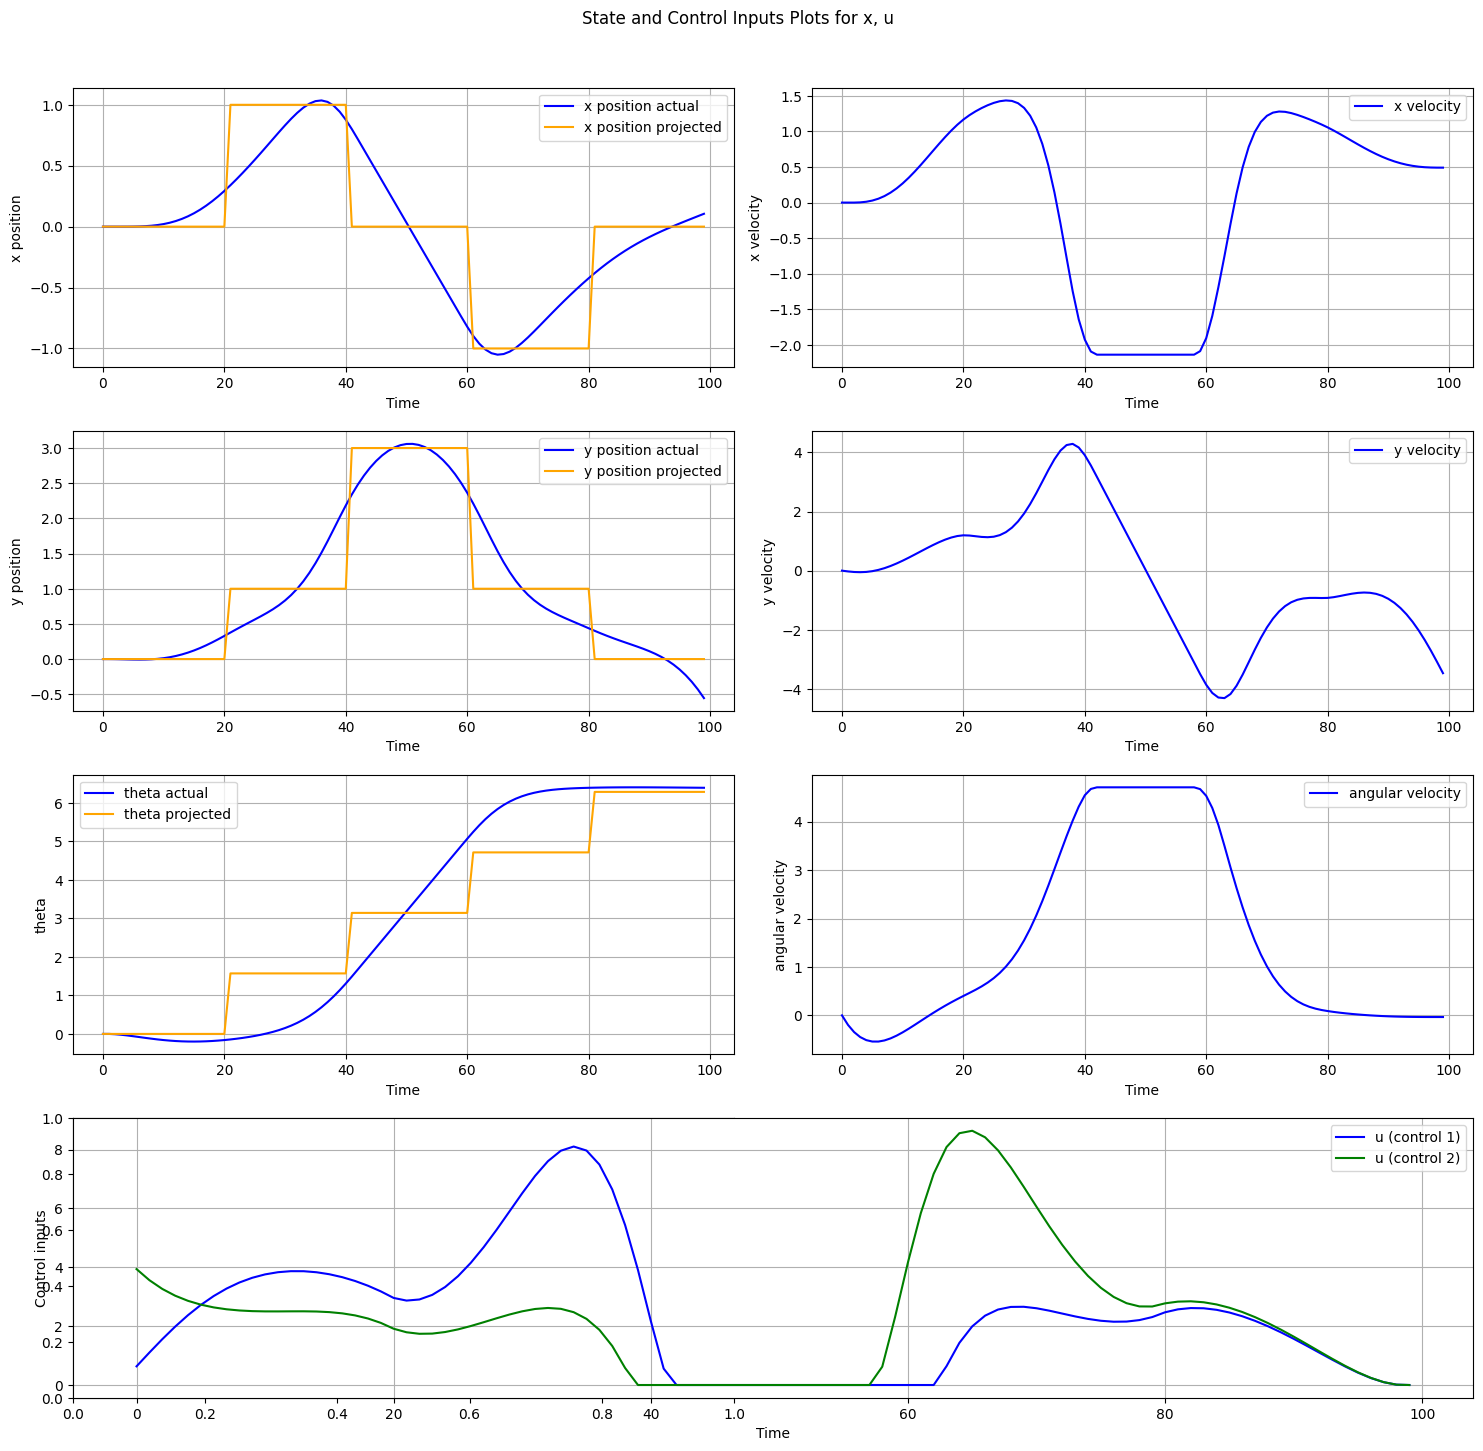

In [245]:
# Set the figure size
x_figsize = 15
y_figsize = 15
# Create a time array based on the number of columns in x
time = np.arange(x.shape[1])
xyt_projected = np.array(
    [find_xk_yk_thetak(x_init=x[0, :6].flatten(), k=k, N=N) for k in time])
# Create a single figure with a 4-row, 2-column layout
fig, axs = plt.subplots(4, 2, figsize=(x_figsize, y_figsize))
fig.suptitle(f"State and Control Inputs Plots for x, u")

# Plot x position
axs[0, 0].plot(time, x[0, :], label='x position actual', color='blue')
axs[0, 0].plot(time, xyt_projected[:, 0],
               label='x position projected', color='orange')
axs[0, 0].set_xlabel('Time')
axs[0, 0].set_ylabel('x position')
axs[0, 0].legend()
axs[0, 0].grid(True)

# Plot x velocity
axs[0, 1].plot(time, x[1, :], label='x velocity', color='blue')
axs[0, 1].set_xlabel('Time')
axs[0, 1].set_ylabel('x velocity')
axs[0, 1].legend()
axs[0, 1].grid(True)

# Plot y position
axs[1, 0].plot(time, x[2, :], label='y position actual', color='blue')
axs[1, 0].plot(time, xyt_projected[:, 1],
               label='y position projected', color='orange')
axs[1, 0].set_xlabel('Time')
axs[1, 0].set_ylabel('y position')
axs[1, 0].legend()
axs[1, 0].grid(True)

# Plot y velocity
axs[1, 1].plot(time, x[3, :], label='y velocity', color='blue')
axs[1, 1].set_xlabel('Time')
axs[1, 1].set_ylabel('y velocity')
axs[1, 1].legend()
axs[1, 1].grid(True)

# Plot theta
axs[2, 0].plot(time, x[4, :], label='theta actual', color='blue')
axs[2, 0].plot(time, xyt_projected[:, 2],
               label='theta projected', color='orange')
axs[2, 0].set_xlabel('Time')
axs[2, 0].set_ylabel('theta')
axs[2, 0].legend()
axs[2, 0].grid(True)

# Plot theta velocity
axs[2, 1].plot(time, x[5, :], label='angular velocity', color='blue')
axs[2, 1].set_xlabel('Time')
axs[2, 1].set_ylabel('angular velocity')
axs[2, 1].legend()
axs[2, 1].grid(True)

# Plot control inputs (u) in the fourth row, spanning both columns
axs[3, 0] = plt.subplot(4, 2, (7, 8))
axs[3, 0].plot(time, u[0, :], label='u (control 1)', color='blue')
axs[3, 0].plot(time, u[1, :], label='u (control 2)', color='green')
axs[3, 0].set_xlabel('Time')
axs[3, 0].set_ylabel('Control inputs')
axs[3, 0].legend()
axs[3, 0].grid(True)

# Remove the unused axis in the fourth row
fig.delaxes(axs[3, 1])

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [246]:
quadrotor.animate_robot(x=x, u=u)

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAZXVtZGF0AAACrwYF//+r
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MyByMzA2MCA1ZGI2YWE2IC0gSC4yNjQvTVBF
Ry00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyMSAtIGh0dHA6Ly93d3cudmlkZW9sYW4u
b3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFs
eXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVk
X3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBk
ZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTE4
IGxvb2thaGVhZF90aHJlYWRzPTMgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50
ZXJsYWNlZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBi
X3B5cmFtaWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29w
PTAgd2VpZ2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj0yNSBzY2VuZWN1dD00MCBpbnRyYV9y
ZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0w
LjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAA
EXVliIQAO//+906/AptFl2oDklcK9sqkJlm5UmsB8qYAAAMAAAMAAAMAABH5cLAuyiEuZJAAAAMA
EzAC3gGqAVYBhT85A0T90eABESP3ATZBsfRWYYKQyH9FYaJhZgC0iWFFh63kMmX7s+0cydB2uiLg
m6NdUr25H+5q/UOrkKsunbzfT9JNmcVIqGu2KgKQ8H07JVOfCdPgyVGNKPlr+M+J41iyL+P7iLKa
LX57COL4/tZXe9o+kP3nhBzjaPp2Ye6fLqRDNKToI0+s4whCIYEU169/Sjd4xrERBBt1j/YiKoTK
XIODL7n5FHGGPl1pQ7tzPGmH3OZvOkVXv0Vj2cr8mXHFl8mMr69WUyGfZHW/f0L75r0DSWqw1h2O
vJKOpQ9P8FecMCCYNd87riOmLIicnHsBMdqrymIhd8zqTyBSQ/pHnV3M22/6j8nr/CzzxB7c42BR
aqfsCisz4sCaS28DFytPt6Y/JixzaQPceIXKg+8AF3VZ3CpIu9YAlvlnXske2obryrrIiSvziYtq
9xvi0R3TvRrRv1mxOOREDXkf5gu4VQJC8cMha17qTiTN8HhirVVd7fJx49q7tGP20dpE3VYns3/V
n3Qaffk8Qk40K8+qSaGSxqc/lekLsPbXxTxhaPivuO0eQGq91Pwe5RR/7Yz9OD1qUOa4HkdiifqP
j2qryhJc6ZstytCa5kKuYYe772IBvsCuHUC4S5av6px3pbaP+GKSwPpDS/4MQWMF/UdjKAjeYi2d
38QbSWbqBNqgQXYZ14f61ui2yM6GOIg7ws1/8vyTk5+nchva+A4izEYbmdjzH7nF6SaKPvJPOn8E
Fb9oMMS0Nz6yx7NhjD52RCX8c7jc4RGj0QGmUMqp9s/2XuJhGtzmZ+UxF3LvlRNhRcLQ+MRBvs+E
oGC3wJ6QtgKAA8w+0qJdOIfQ8XfEyDsqUz4MMdMfI5BOqjS+wtyAgAAAAwNveuG4AAFA9UO8HIKw
iV3s+2BrhvqgxAfBoCD2RrYIMfgb6bfOqp+eZpzbm2E2wQlSIvOpU1QqWkVxhMlOcSHSzbW+iHaV
oC9zrBPj/y5/fqYLXy9Zh4Ne3rnPdXGXsu0sSIF1lV/HvWJ7KysPgU/0tFMP9VtmM8zPHl9wruRl
U6fqIQ2A8cIsMWzRdk7xaLDSDQ1oenNfLnLWBgsnFEV1SVknn2T/4hXFUppZvSn2t7UFEftQZ9x/
8l0apCp2BE3OHXYYHe510+L2LfltY+t0pcIwXF7R/OXamNU3t8byrOJW9DqsbDlWwQdFmYnp6ffq
XrT1JUupjyF+F/98JBCQDfFSCf0AvDv8oioizbTiyWQE5bY5V3QH1GUmdMAehvIwfBiTZWWi6fQ7
dmzphxSw6rVp6oK/5vmrPY56z6eIgcgRrmpCoccbdgAAAwAAAwMe2O2VAvnzZMAOYXl5Jqx4HiBa
BvYjcBjG0b3e3JaimuLFhrHRMSWZH2WXllK0WzScL2WGizB/ekTdy0Qj6v0VxsxmCERSLhJ5jzqr
CtHfRstS+e+33jCGV9cYoc7pM8evwS6OHLAmsx359ZjvFooOcbfjpOuDbE9ydErRNMsNrG9Zq+tk
WfYzYmJWswcdSRM5//5NWQ+1dO5pDAOUDqALGMpj35P9EqkKJfLfdQCrgW05JFiGr9rWma7Ejg+y
QBBk/h85TXs1E4/wzb/2kGNoKOUz+RzSfXk3eeTMCjNgTJ5NKBn4bYY/l8VWN5leDx1ux0u0fvaZ
OYTt7nHytnMp39ZMLuXxtXaR7rleXMVFfF/NxUbeBQmwOC7Lx/opNBqhx/5cueJjt7O55GH/QhWB
f591+qoBKpqvyFJzOTzqReBYx8P79mJdx0Mv+HL4+yScuS/TXcCVmU4JjBgFYemBPXAzHvNpwUxK
ywb1iJ/6W+DPl/QM61ToHPSe5IUQB9YfGmLsm+5OTwAAjzSzqVFYAVBYFIi106Qgp4TQVb1++yAT
Xi7sEN/9EQ3/zGwoxAQT6dh7JPSHDiY4SeQJg37/PDAixERacKpfnkyVIkaBtz9cTQrzGlfWvnf2
YO84748BmhNgDAvxyOeBBX/mfPe2E8iX9owK0nlPq8P7W2POgex7e/61yIx89+knq2AgRocT70R/
VheX940+bp6V349F9jaMpNLuP2uVfexUueV4DeQ57nM2sQkrfr3wlriWmwTeChv5OE/rqsnmWe60
NhnScoHUT5Ez/lIQ1GLl1Sc/KaUNIKUJnuhIiOYxlr6sGuUlzGJ24sqqKGO2c5RXqM5mw+TNXrQD
IQYba9SrWyEPzn6mP9Wyax6ThSa6nOyrTr4dF6BP7ZlCVYJb68/+ELcMbQOAQjTJWARF+6HQuYo8
O/rF3d5js18J84I3r/KfPJTRufNSFtA2SaWTAqdDMoOnmxk8hJ+pCIJsa/KEmWbsqbNIRXTxcZUC
943/1qBMlE9p6nyPHhGSSwpjoLWwdPlETyWPG331QOn/rUNeOlUI/pf6fpPCktYmCtWKeu6KCAAB
E3JMjPk1Z8TAIKMHoW/O8DTFRc2/plKw0X68dlIq+eLLzXzZhjCySejFXtSoDHFv84fPyFbYhp1X
Ak/gpqErvaJ9JGxwZEg+XZrQNNQQ7qf23OjEF9KF0m9MAF0Bxe+kzXgxfnB+olUPkwPuDn99iCiJ
qgG7e/pAEMvIc6kmOYqfAMgb39QNCcAAAAMAAgMjrFjzsG5OUZg17GV6yQJcm/qNAnBNl3Rks7Jw
m7gtZhOFCvtE4Fe1M+fD2NXXq4BgcUszAmtqLGVw62OicjQHjnurPjl3+erN8bn0HXTDhz1Zwa/K
T6O2DJmfStlOHM/8Mlbn5D99ovmg0M3qADvmoHBPjG+2srmfiN8GI9hLI4HlyMhpw2dJy+H5fd78
BcoY5avYVbUq5W2ur7Ip6